In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pathresults = "../../results/"
#pathresults = "/DUMUXDune27/DUMUX/dumux-rosi/python/paperSc/results/"
data_file_delimiter = ","
import re

evalTime = 25.

In [36]:
def getVal(mypath, filename, header="infer",names = None):
    fullpath = pathresults +mypath+filename
    if names is None:
        cst = pd.read_csv(fullpath,delimiter=data_file_delimiter, header = header).dropna(how= "all", axis=1)
    else:
        cst = pd.read_csv(fullpath,delimiter=data_file_delimiter, header = header, names = names).dropna(how= "all", axis=1)
    return cst

def getTimeLine(path2file, evalTime):
    time = pd.read_csv(pathresults + path2file + "time.txt", names = ["time","Qlight"])["time"][1:] # because we have twice the initial value
    time_diff = abs(np.array(time)-evalTime)
    timeLineNeg = len(time_diff) - np.where(time_diff == min(time_diff))[0][0] 
    timeLinePos = len(time_diff) -timeLineNeg
    print('timeLine',timeLineNeg,timeLinePos, min(time_diff) )
    return timeLineNeg, timeLinePos
    
def get_last_line_as_numpy_array(file_path, timeLine,pos = False, dtype = float, verbose = False):
    with open(pathresults +file_path, 'r') as file:
        # Read all lines
        lines = file.readlines()

        # Check if there are any lines in the file
        if not lines:
            raise ValueError("The file is empty")

        # Get the last line
        
        try:
            if pos:
                last_line = lines[timeLine-1].strip()
            else:
                last_line = lines[-timeLine-1].strip()
        except:
            print('timeLine',file_path, len(lines)-timeLine, len(lines))
            raise Exception

        # Split the last line by commas and convert to NumPy array
        array_from_last_line = np.array(last_line.split(','), dtype=dtype)
        if verbose:
            print(file_path, len(array_from_last_line), end=", ")

        return array_from_last_line

def getCylIdx(path2file, timeLinePos):
    fileName = "rhizoSegsId.txt"
    fullpath = path2file+fileName
    rhizoSegsId = get_last_line_as_numpy_array(fullpath, timeLinePos,pos=True, dtype = int, verbose = True)
    print('rhizoSegsId',max(rhizoSegsId))
    return rhizoSegsId
    
def list_files_with_prefix(folder_path, prefix):
    file_names = []
    for file_name in os.listdir(pathresults+folder_path):
        if file_name.startswith(prefix):
            file_names.append(file_name)
    return file_names

# cylinder max konz (per cell)
def getData_(cid,gId,path2file, timeLineNeg):
    fileName = "cyl_val/Cyl_cellVol_"+str(gId)+".txt"
    cVol = get_last_line_as_numpy_array(path2file+fileName, timeLineNeg,pos= False, dtype = float)
    if cid == volIdx:
        return sum(cVol)
    elif cid <= 9:
        if cid <= 2:# == 0:
            fileName = "cyl_val/Cyl_watercontent_"+str(gId)+".txt"
            theta = get_last_line_as_numpy_array(path2file+fileName, timeLineNeg,pos= False,  dtype = float)
            cVol *= theta#cm3 scv to cm3 water
            if cid == 0:
                return sum(cVol)
        fileName = "cyl_val/Cyl_content"+str(cid)+"_"+str(gId)+".txt"
        Q1 = get_last_line_as_numpy_array(path2file+fileName, timeLineNeg, pos= False, dtype = float)
        konz = sum(Q1)/sum(cVol) #mol/cm3 or cm3/cm3
        return konz
    raise Exception

nKonz = 9
dictXYZ = {9:'X',10:'Y',11:'Z'}
volIdx=12
lenIdx=13
stIdx=14
orgIdId=15
relLenId=16

nToGet = relLenId+1 #elements + 3d coordinates of y , node+vol+len+st 
# baseline_1080_19_10to25_20mn_0s_128
path2file = r'newMucil4p/{}_1476_{}_10to25_20mn_0s_128/'
scenarios = ["earlyDry", "baseline", "lateDry"]
setIds = [17,38,44,85]
exceptPset = []#[('baseline','19'),('baseline','47'),('baseline','83')]
#result_list_compExcept = [path2file.format(scenario, str(setId)) for scenario, setId in exceptPsets]
result_list_comp = [path2file.format(scenario, str(setId)) for scenario in scenarios for setId in setIds if (scenario, str(setId)) not in exceptPset ]

numPset = len(result_list_comp)
allPSets = [ i for i in range(numPset) if i not in exceptPset]

def getData():
    
    GiniAll = [[[] for i in range(numPset)] for ii in range(nToGet)]
    
    for pSet in allPSets:
        print(pSet,end =", ")
        if True:

        #try:
            #path2file = 'none_55_'+str(pSet)+'_10to11_20mn_0s_5/'
            path2file =result_list_comp[pSet]# "forEGU"+scenarios[pSet]+"_1440_76_10to25_20mn_0s_128/"

            time = pd.read_csv(pathresults + path2file + "time.txt", names = ["time","Qlight"])["time"][1:] # because we have twice the initial value
            timemax = int((max(time))*10)/10
            print('timemax',timemax, timemax==25)
            
            if(timemax==25):
                timeLineNeg, timeLinePos = getTimeLine(path2file, evalTime)
                rr = getCylIdx(path2file, timeLinePos)

                rr.sort()
                print('(',len(rr),')',end =", ")

                for cid in range(nKonz):
                    Ginits = np.array([getData_( cid, gId,path2file, timeLineNeg) for gId in rr])          
                    GiniAll[cid][pSet] = Ginits
                for cid in range(nKonz,volIdx):
                    nodes_ = get_last_line_as_numpy_array(path2file+"nodes_"+dictXYZ[cid]+".txt", timeLinePos,pos = True, dtype =float)
                    GiniAll[cid][pSet] = nodes_[rr+1]#seg idx to y-idx
                #cid = nToGet -1
                Ginits = np.array([getData_( volIdx, gId,path2file, timeLineNeg) for gId in rr])
                GiniAll[volIdx][pSet] = Ginits
                lens = get_last_line_as_numpy_array(path2file+"length_Segs"+".txt", timeLinePos,pos = True, dtype =float, verbose = True)
                GiniAll[lenIdx][pSet] = lens[rr]
                sts = get_last_line_as_numpy_array(path2file+"subTypes"+".txt", timeLinePos,pos = True, dtype =float, verbose = True)
                assert len(sts) == len(lens)
                GiniAll[stIdx][pSet] = sts[rr]

                orgidPerNode = get_last_line_as_numpy_array(path2file+"orgidPerNode.txt", timeLinePos,pos = True, dtype =int, verbose = True)
                globalNodeId = get_last_line_as_numpy_array(path2file+"globalNodeId.txt", timeLinePos,pos = True, dtype =int, verbose = True)
                parentNidx = get_last_line_as_numpy_array(path2file+"parentNidx.txt", timeLinePos, pos = True,dtype =int, verbose = True)
                ot_orgs = get_last_line_as_numpy_array(path2file+"ot_orgs.txt", timeLinePos,pos = True, dtype =int, verbose = True)
                id_orgs = get_last_line_as_numpy_array(path2file+"id_orgs.txt", timeLinePos, pos = True,dtype =int, verbose = True)
                id_roots = id_orgs[np.where(ot_orgs==2)]

                org2basenode = dict(zip(id_orgs, parentNidx))
                #org2ot = dict(zip(id_orgs, ot_orgs))
                isRoot = np.array([oo in id_roots for oo in orgidPerNode])

                orgidPerRoot = orgidPerNode[np.where(isRoot)]
                globalNodeIdroot =  globalNodeId[np.where(isRoot)]        
                segIdxRoot = np.array([rr for _, rr in enumerate(globalNodeIdroot) if rr != org2basenode[orgidPerRoot[_]]]) -1
                orgIdxRoot = np.array([orgidPerRoot[_] for _, rr in enumerate(globalNodeIdroot) if rr != org2basenode[orgidPerRoot[_]]])
                #segIdx2ot = dict(zip(segIdxRoot,orgIdxRoot))

                relLens = np.zeros(len(segIdxRoot))
                #lens = get_last_line_as_numpy_array(path2file+"length_Segs"+".txt", dtype =float)
                for myorg in orgIdxRoot:
                    thensegs = np.where(orgIdxRoot == myorg)#segIdxRoot[] 
                    lenSegs = GiniAll[lenIdx][pSet]
                    relLens[thensegs] = np.cumsum(lenSegs[thensegs])


                GiniAll[orgIdId][pSet] = orgIdxRoot
                GiniAll[relLenId][pSet] = relLens
            #except:
            #    print('jump',end =", ")

    return GiniAll #cid pSet rr
    

In [37]:

GiniAll = getData()

0, timemax 25.0 True
timeLine 1 1079 4.227729277772596e-13
newMucil4p/earlyDry_1476_17_10to25_20mn_0s_128/rhizoSegsId.txt 783, rhizoSegsId 850
( 783 ), newMucil4p/earlyDry_1476_17_10to25_20mn_0s_128/length_Segs.txt 851, newMucil4p/earlyDry_1476_17_10to25_20mn_0s_128/subTypes.txt 851, newMucil4p/earlyDry_1476_17_10to25_20mn_0s_128/orgidPerNode.txt 851, newMucil4p/earlyDry_1476_17_10to25_20mn_0s_128/globalNodeId.txt 851, newMucil4p/earlyDry_1476_17_10to25_20mn_0s_128/parentNidx.txt 376, newMucil4p/earlyDry_1476_17_10to25_20mn_0s_128/ot_orgs.txt 376, newMucil4p/earlyDry_1476_17_10to25_20mn_0s_128/id_orgs.txt 376, 1, timemax 18.3 False
2, timemax 25.0 True
timeLine 1 1079 4.227729277772596e-13
newMucil4p/earlyDry_1476_44_10to25_20mn_0s_128/rhizoSegsId.txt 782, rhizoSegsId 849
( 782 ), newMucil4p/earlyDry_1476_44_10to25_20mn_0s_128/length_Segs.txt 850, newMucil4p/earlyDry_1476_44_10to25_20mn_0s_128/subTypes.txt 850, newMucil4p/earlyDry_1476_44_10to25_20mn_0s_128/orgidPerNode.txt 850, newMuc

In [38]:
dataInput =  [(scenario, str(setId)) for scenario in scenarios for setId in setIds if (scenario, str(setId)) not in exceptPset ]

In [39]:
# get param set
outputvalsname =  ['wat','cs','cl','coa','cod','cca','ccd','css2','co2','yX','yY','yZ','vol','lenSeg','st','orgId','relLen']
assert len(outputvalsname) == nToGet 
column_names = outputvalsname + ['scenario']
df = pd.DataFrame(columns=column_names)

for pset, din in enumerate(dataInput):#range(numPset):
    try:
        N = GiniAll[0][pset].shape[0]
        #assert N == 232
        rows_df = pd.DataFrame()

        for jj, outVn in enumerate(outputvalsname):
            rows_df[outVn] = GiniAll[jj][pset]
            #print('adding',jj,outVn,duplicated_rows_df.shape,len(GiniAll[jj][pset]))
        rows_df['scenario'] = din[0]
        rows_df['pSet'] = din[1]

        df = pd.concat([df, rows_df], ignore_index=True)
    except:
        print('jump',pset, din)
df['co'] = df['coa']+df['cod']
df['cc'] = df['cca']+df['ccd']

jump 1 ('earlyDry', '38')


In [40]:
df.to_pickle('./4paramTempRS25.pkl')

In [91]:
df['time'] = evalTime

In [43]:

#outputvalsname =  ['wat','cs','cl','coa','cod','cca','ccd','css2','co2','yX','yY','yZ']
#column_names = outputvalsname + paramsets.columns.tolist()
def getnewval(df):
    #outputvalsname =  ['wat','cs','cl','coa','cod','cca','ccd','css2','co2','yX','yY','yZ']
    #column_names = outputvalsname + paramsets.columns.tolist()
    
    df["simulation"] = df["pSet"].apply(str) +"_"+ df["scenario"]  
    df['css']=df['css2']
    df['cxd']=df['cod']+df['ccd']
    df['cxa']=df['coa']+df['cca']
    df['cx']=df['co']+df['cc']
    df['cxd_cx']=df['cxd']/df['cx']
    df['cxa_cx']=df['cxa']/df['cx']
    df['theta']=df['wat']/df['vol']
    #df  = pd.merge(df, paramsets[['pSet', 'theta_th']], on="pSet")
    #df['csBis'] = df['cs']*df['theta']/df['theta_th']
    #df['clBis'] = df['cl']*df['theta']/df['theta_th']
    # per unit of soil volume
    df['cs_'] = df['cs']*df['theta']
    df['cl_'] = df['cl']*df['theta']
    
    df['height'] = df['yZ']
    
    df['css'] = df['css2']#*mg_per_mol/solidDensity_gcm3
    df['CLl']=df['cs_']#*dfa['vol']
    df['cs_/css']=df['cs_']/df['css']
    #df.loc[df['scenario'] == "earlyDry",'scenario']="earlyDry"  # Select subset where 'pSet' equals the current value
    
    solidDensity = 2650 # [kg/m^3 solid] #taken from google docs TraiRhizo
    solidMolarMass = 60.08e-3 # [kg/mol] 
    thetaS= 0.43
    mgC_per_molC=12.011*1000
    
    massBulkDensity = solidDensity*(1.- thetaS) *1000 /1e6 # [kg/m^3 scv] * [g/kg] * [m3/cm3] = g/cm3
    #df['pSet']=df['scenario']+'_'+df['pSet']

    # mol/cm3 scv to mg C pool/g C mineral
    if True:
        for nnn in ['cs_','cl_','co','cc','coa','cod','cca','ccd','css2']:
            # mol C/cm3 *  
            df[nnn+'_mass'] = df[nnn]*mgC_per_molC / massBulkDensity
    return df
df = getnewval(df)

In [ ]:
df18 = getnewval( pd.read_pickle('./4paramTemp18.0.pkl')) # getnewval(df)
df11 = getnewval( pd.read_pickle('./4paramTemp11.pkl') )
dfall = pd.concat([df,df18,df11 ])
dfall['time'] = dfall['time'].astype(int)

cs for pset 44_earlyDry 18 r_squared 0.02830902646007427 initial slope -2.886040207710704e-08


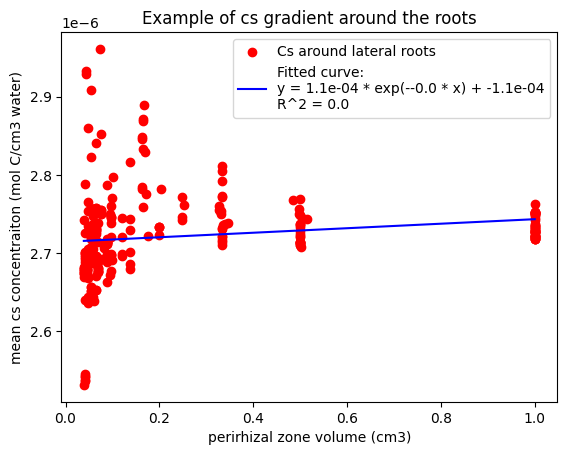

cs for pset 85_baseline 25 r_squared 0.49395960143751294 initial slope 2.3892488457367084e-05


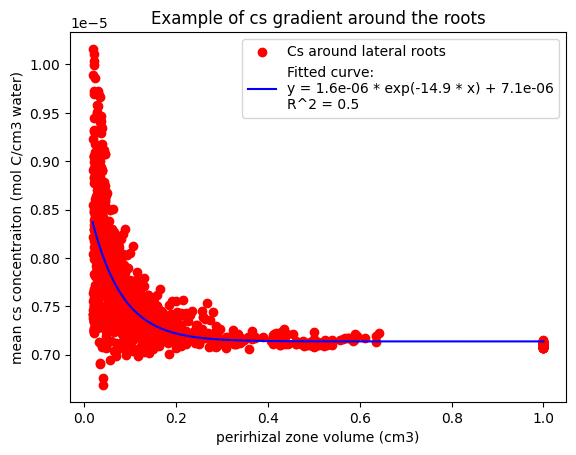

In [133]:
from scipy.optimize import curve_fit

# Define a negative exponential function
def negative_exponential(x,a,  b, c):
    return a * np.exp(-b * x) + c

def constant(b,x):
    return np.full(x.shape,b)

def getInitcurve(df, varname):

    df[varname+'a_fit'] = np.nan
    df[varname+'b_fit'] = np.nan
    df[varname+'c_fit'] = np.nan
    #df[varname+'cs_slope'] = np.nan
    df[varname+'r_squared'] = np.nan
    survivors = df["simulation"].unique()
    for pepe in survivors:#df['pSet'].unique():
        for tt in df["time"].unique() :
            # Sample data
            #df_data = df[(df['simulation']==pepe)&((df['st']==1)|((df['st']==2)))]#&(df['relLen']<=2)]
            df_data = df[(df['simulation']==pepe)&(df['time'].astype(int)==tt)&((df['st']==1)|((df['st']==2)))].copy()
            x_data = df_data['vol']
            y_data = df_data[varname]


            # Use curve_fit to find the best parameters
            # Provide initial guesses for a and b
            initial_guess = [max(y_data)-min(y_data), 2, min(y_data)]
            params, covariance = curve_fit(negative_exponential, x_data, y_data, p0=initial_guess)

            # Extract the parameters
            a_fit, b_fit, c_fit = params


            # Plot the data and the fitted curve
            x_fit = np.linspace(min(x_data), max(x_data), 100)  # Finer x range for a smooth curve
            y_fit = negative_exponential(x_fit, a_fit, b_fit, c_fit)
            residuals = y_data- negative_exponential(x_data, *params)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((y_data-np.mean(y_data))**2)
            r_squared = 1 - (ss_res / ss_tot)


            if r_squared < 0.5:
                cs_slope = a_fit * b_fit
                print(varname,'for pset',pepe, tt, 'r_squared',r_squared,'initial slope', a_fit * b_fit)
                plt.scatter(x_data, y_data, label="Cs around lateral roots", color='r')  # Original data
                plt.plot(x_fit, y_fit, 
                         label=f"Fitted curve:\ny = {a_fit:.1e} * exp(-{b_fit:.1f} * x) + {c_fit:.1e}\nR^2 = {r_squared:.1f}", color='b')  # Fitted curve




                plt.xlabel("perirhizal zone volume (cm3)")
                plt.ylabel("mean cs concentraiton (mol C/cm3 water)")
                plt.title("Example of cs gradient around the roots")
                plt.legend()
                plt.show()

            df.loc[((df['simulation']==pepe)&(df['time'].astype(int)==tt)), varname+'a_fit']= a_fit
            df.loc[((df['simulation']==pepe)&(df['time'].astype(int)==tt)),varname+'b_fit'] = b_fit
            df.loc[((df['simulation']==pepe)&(df['time'].astype(int)==tt)),varname+ 'c_fit']= c_fit
            df.loc[((df['simulation']==pepe)&(df['time'].astype(int)==tt)),varname+'r_squared'] = r_squared
for varname in ['cs', 'cc','co'] :#'css2','co2',       
    getInitcurve(dfall, varname)

In [135]:
dfall

,wat,cs,cl,coa,cod,cca,ccd,css2,co2,yX,...,co2r_squared,coa_fit,cob_fit,coc_fit,cor_squared,cca_fit,ccb_fit,ccc_fit,ccr_squared,time
0,0.030374,0.000004,0.000774,2.825064e-06,6.690099e-06,2.426173e-07,0.000019,0.000088,0.000185,-0.298434,...,0.802343,1.783624e-06,46.625476,0.000009,0.844278,2.429602e-05,36.306413,0.000011,0.797216,25
1,0.004686,0.000007,0.000539,1.037475e-05,8.054194e-08,8.016365e-07,0.000030,0.000154,0.000412,0.043922,...,0.802343,1.783624e-06,46.625476,0.000009,0.844278,2.429602e-05,36.306413,0.000011,0.797216,25
2,0.004716,0.000007,0.000636,9.978678e-06,8.903254e-08,6.863449e-07,0.000026,0.000152,0.000334,-0.447197,...,0.802343,1.783624e-06,46.625476,0.000009,0.844278,2.429602e-05,36.306413,0.000011,0.797216,25
3,0.005157,0.000007,0.000644,9.874598e-06,1.591524e-07,6.082386e-07,0.000026,0.000146,0.000317,-0.104340,...,0.802343,1.783624e-06,46.625476,0.000009,0.844278,2.429602e-05,36.306413,0.000011,0.797216,25
4,0.004778,0.000007,0.000632,9.979356e-06,1.064768e-07,6.696992e-07,0.000027,0.000150,0.000342,-0.125120,...,0.802343,1.783624e-06,46.625476,0.000009,0.844278,2.429602e-05,36.306413,0.000011,0.797216,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2151,0.218450,0.000007,0.000749,8.904080e-07,8.373327e-06,6.951947e-07,0.000009,0.000163,0.000001,0.941138,...,NaN,8.700342e-10,21.774673,0.000009,0.901733,8.603875e-08,21.565137,0.000009,0.901553,11
2152,0.110273,0.000007,0.000749,8.926621e-07,8.371085e-06,7.067319e-07,0.000009,0.000163,0.000001,-0.703023,...,NaN,8.700342e-10,21.774673,0.000009,0.901733,8.603875e-08,21.565137,0.000009,0.901553,11
2153,0.015282,0.000008,0.000749,9.140686e-07,8.349827e-06,7.945960e-07,0.000009,0.000170,0.000001,0.042671,...,NaN,8.700342e-10,21.774673,0.000009,0.901733,8.603875e-08,21.565137,0.000009,0.901553,11
2154,0.015282,0.000008,0.000749,9.140686e-07,8.349827e-06,7.945960e-07,0.000009,0.000170,0.000001,0.142705,...,NaN,8.700342e-10,21.774673,0.000009,0.901733,8.603875e-08,21.565137,0.000009,0.901553,11


In [174]:
ymins = [np.Inf, np.Inf, np.Inf]
ymaxs = [-np.Inf, -np.Inf, -np.Inf]
survivors = df["simulation"].unique()
for ii, varname in enumerate(['cs','cc','co'] ): 

    for jj, age_ in enumerate([11,18,25] ): 
        for pepe in survivors:
            df_data = dfall[(dfall['simulation']==pepe)&(dfall['time'].astype(int)==age_)&((dfall['st']==1)|((dfall['st']==2)))].copy()
            x_data = df_data['vol']
            x_fit = np.linspace(min(x_data), max(x_data), 100)  # Finer x range for a smooth curve
            a_fit = df_data[varname+ 'a_fit'].unique()
            b_fit= df_data[varname+'b_fit'].unique()  
            c_fit = df_data[ varname+'c_fit'].unique()
            y_fit = negative_exponential(x_fit, a_fit, b_fit, c_fit)
            ymins[ii] = min(min(y_fit)-0.1*min(y_fit),ymins[ii] )
            ymaxs[ii] = max(max(y_fit)*1.2,ymins[ii] )

In [175]:
print(ymins,ymaxs)

[7.464139357736946e-08, 8.391206124137403e-06, 8.330562249445088e-06] [9.935058841909358e-06, 2.9503201195532577e-05, 1.1437376661963954e-05]


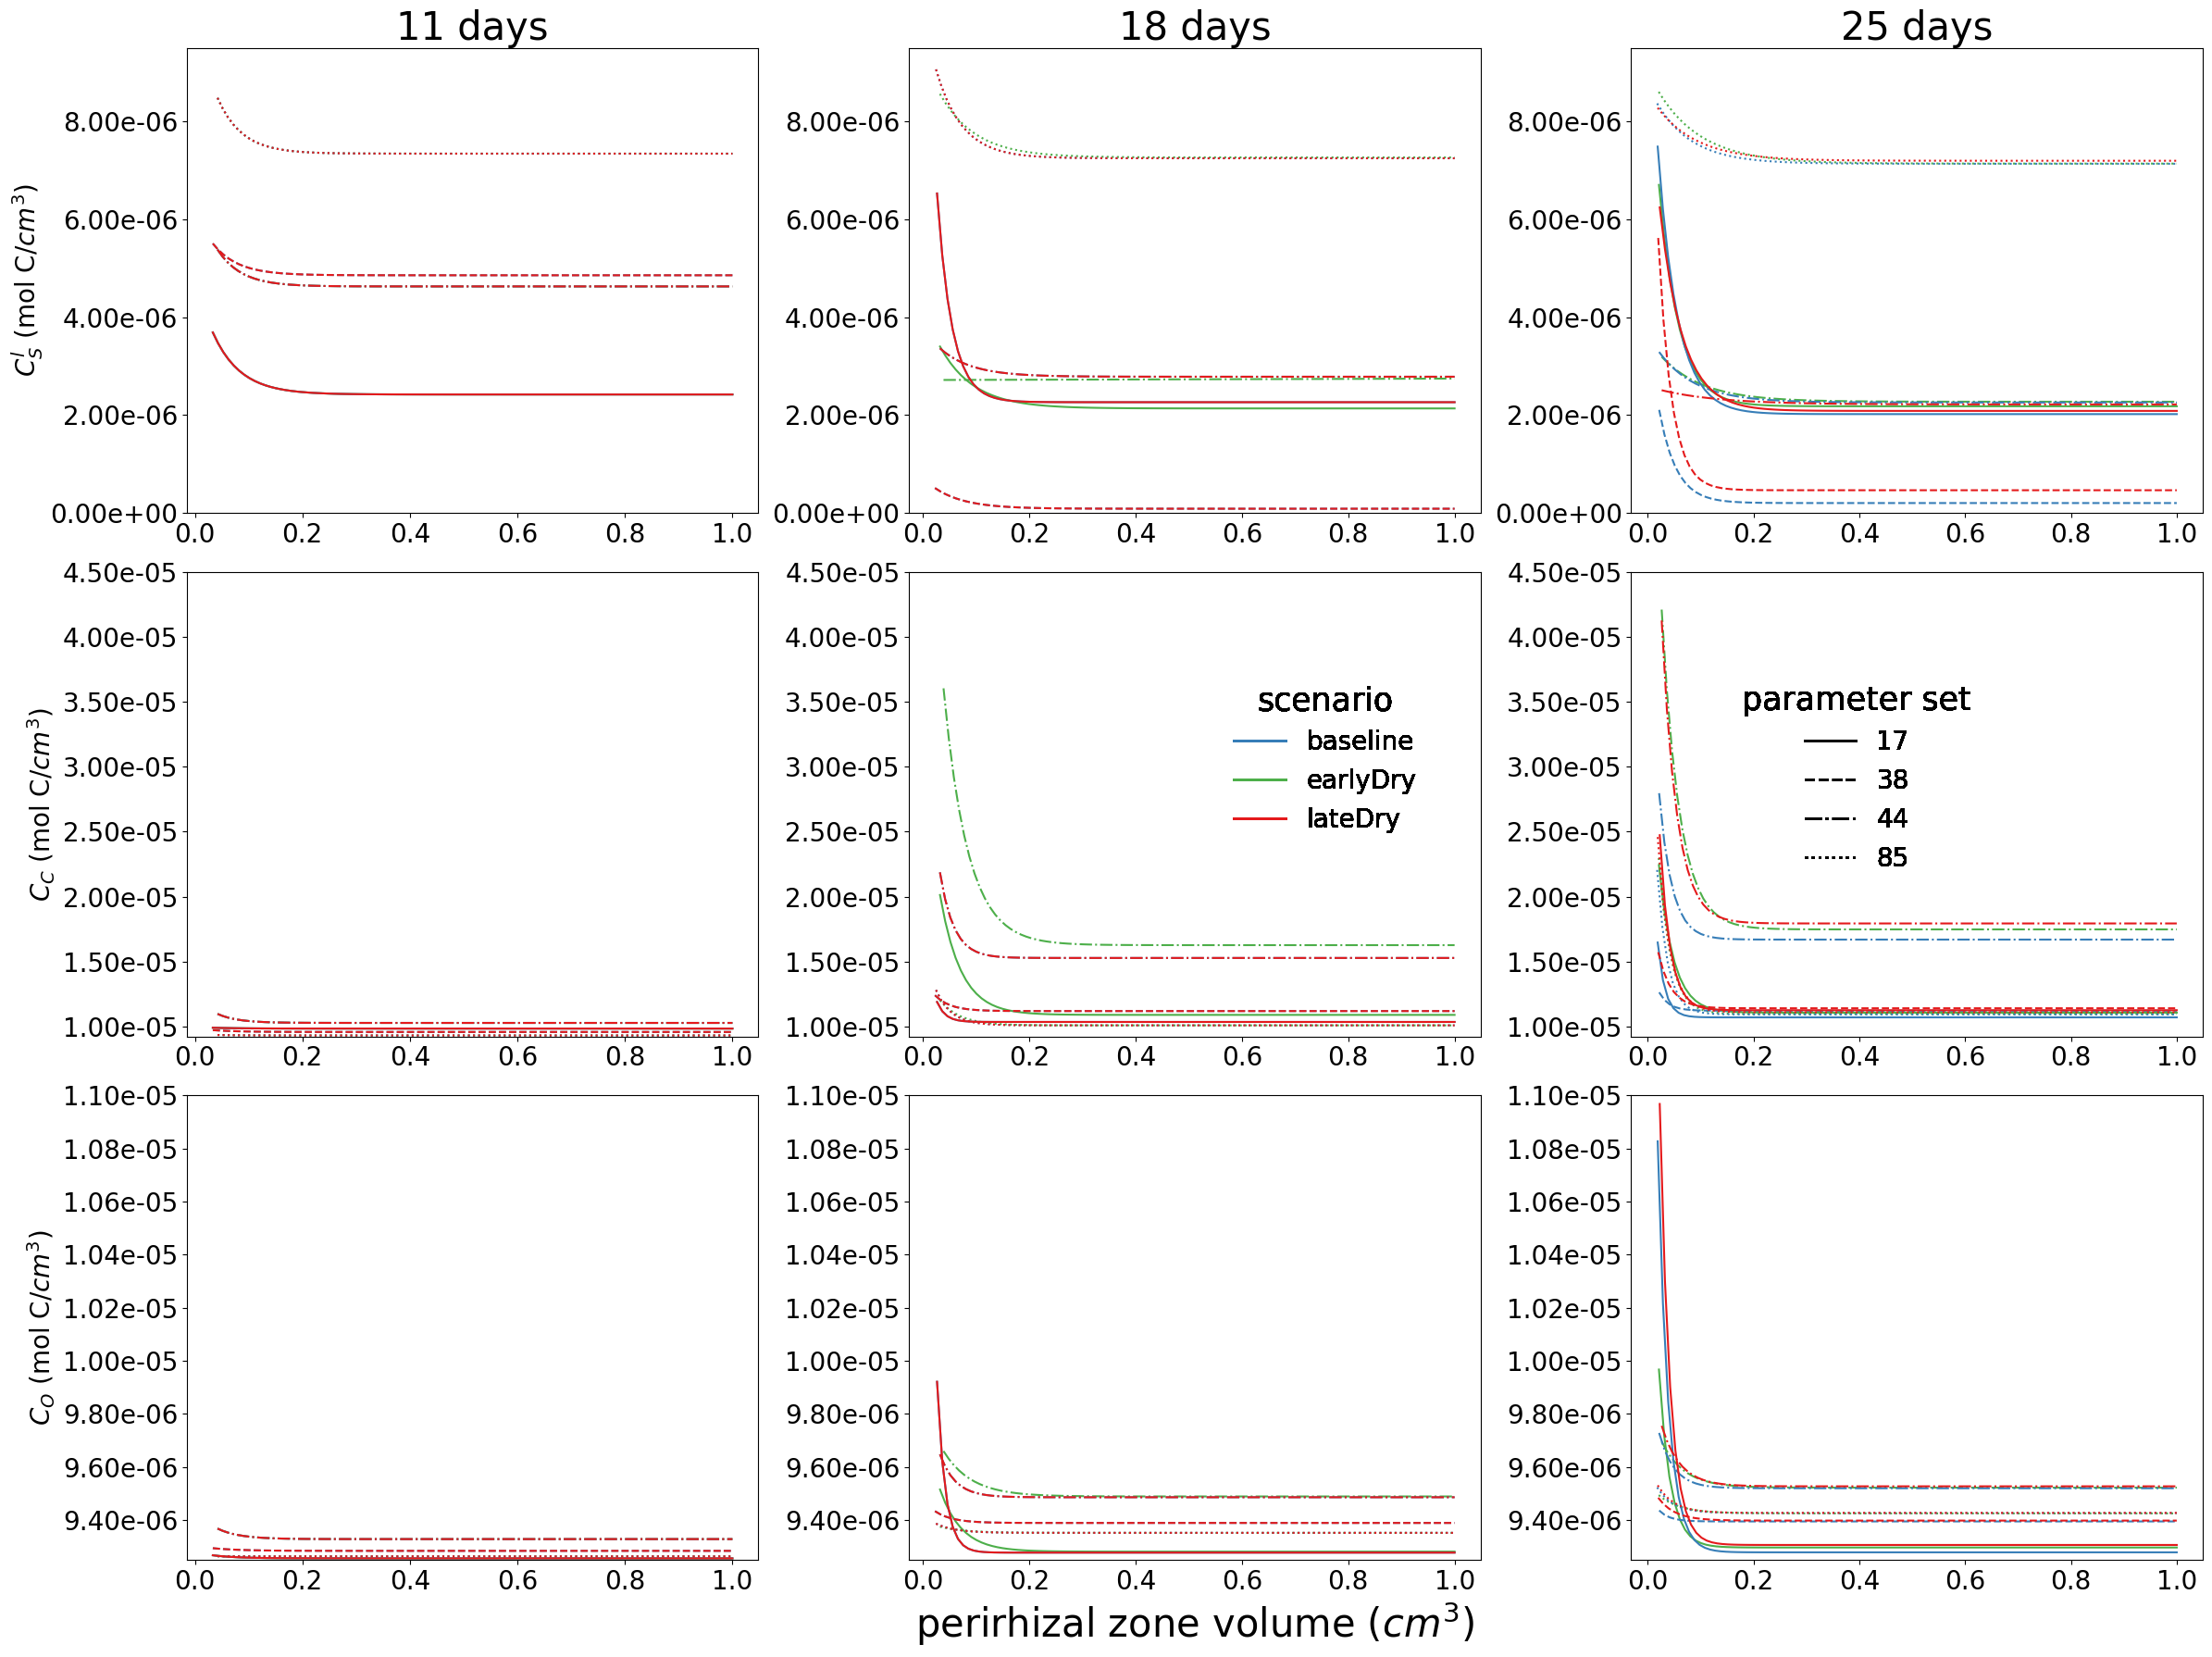

In [187]:

from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter


l_styles = {17:'-',38:'--',44:'-.',85:':'}
# Define the color dictionary
c_styles = {
    'baseline':'#377EB8',  # Blue
    'earlyDry':  '#4DAF4A' ,  # Green
    'lateDry': '#E41A1C'  # red
}
# Color legend
color_legend_elements = [
    Line2D([0], [0], color=c_styles['baseline'], lw=2, label='baseline'),
    Line2D([0], [0], color=c_styles['earlyDry'], lw=2, label='earlyDry'),
    Line2D([0], [0], color=c_styles['lateDry'], lw=2, label='lateDry')
]

# Line style legend
linestyle_legend_elements = [
    Line2D([0], [0], color='black', linestyle=l_styles[17], lw=2, label=17),
    Line2D([0], [0], color='black', linestyle=l_styles[38], lw=2, label=38),
    Line2D([0], [0], color='black', linestyle=l_styles[44], lw=2, label=44),
    Line2D([0], [0], color='black', linestyle=l_styles[85], lw=2, label=85)
]

ylabels = {'cs': '$C_S^l$','co2': '$CO_2$','cc': '$C_C$','co': '$C_O$' }  
def getgradcurve(df,fig, ax,ii,jj,age, varname, ymin=None, ymax=None, dology = False, 
                 dologx = False, anchor2=(0.9, 0.6)):
    idplot= ii*jj
    survivors = df["simulation"].unique()
    
    for pepe in survivors:#df['pSet'].unique():
        #print('pepe', pepe)
        df_data = df[(df['simulation']==pepe)&(df['time'].astype(int)==age)&((df['st']==1)|((df['st']==2)))].copy()
        x_data = df_data['vol']
        y_data = df_data['cs']
        

        a_fit = df_data[varname+ 'a_fit'].unique()
        b_fit= df_data[varname+'b_fit'].unique()  
        c_fit = df_data[ varname+'c_fit'].unique()
        r_squared = df_data[varname+'r_squared'].unique() 
        # Plot the data and the fitted curve
        x_fit = np.linspace(min(x_data), max(x_data), 100)  # Finer x range for a smooth curve
        y_fit = negative_exponential(x_fit, a_fit, b_fit, c_fit)
        

        ax.plot(x_fit, y_fit,
                 c=c_styles[df_data['scenario'].unique()[0]],
                 linestyle=l_styles[int(df_data['pSet'].unique()[0])]
                )


        ax.tick_params(axis='both', which='major', labelsize=20)

        # Set x-axis to scientific format
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 2))
        ax.yaxis.set_major_formatter(formatter)
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2e}'))
        if (ymin is not None) and  (ymax is not None):
            ax.set_ylim(ymin, ymax)

        if dology:
            ax.set_yscale('log')
        if dologx:
            ax.set_xscale('log')
        if jj == 0:
            ax.set_ylabel(ylabels[varname]+" (mol C/$cm^3$)", fontsize=20)
        if (ii == 0):
            if (jj==0):
                ax.set_title("11 days", fontsize=30)
            if (jj==1):
                ax.set_title("18 days", fontsize=30)
            if (jj==2):
                ax.set_title("25 days", fontsize=30)
        if (ii == 2) and (jj==1):
            ax.set_xlabel("perirhizal zone volume ($cm^3$)", fontsize=30)
        if idplot == 1:
        
            # Create color legend
            color_legend = fig.legend(handles=color_legend_elements, title='scenario', title_fontsize=25,
                                      bbox_to_anchor=(0.65, 0.6), frameon=False, fontsize=20)

            # Create line style legend
            linestyle_legend = fig.legend(handles=linestyle_legend_elements, title_fontsize=25,
                                          title='parameter set', bbox_to_anchor=anchor2,fontsize=20, frameon=False)
            #bbox_to_anchor=(0.88, 1),

            # Add both legends to the plot
            plt.gca().add_artist(color_legend)
            plt.gca().add_artist(linestyle_legend)
        
ymins = [0,9.25e-6, 9.25e-6]
ymaxs = [9.5e-6,4.5e-5,1.1e-5]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8*3, 6*3))
for ii, varname in enumerate(['cs','cc','co'] ): 

    for jj, age_ in enumerate([11,18,25] ): 
        getgradcurve(dfall,fig, axes[ii,jj], ii,jj, age= age_, varname = varname, 
                     dology = False , ymin=ymins[ii],ymax=ymaxs[ii]
                    ) # rint(ymins,ymaxs)
plt.tight_layout()

plt.savefig('gradroot.png')
plt.show()
    

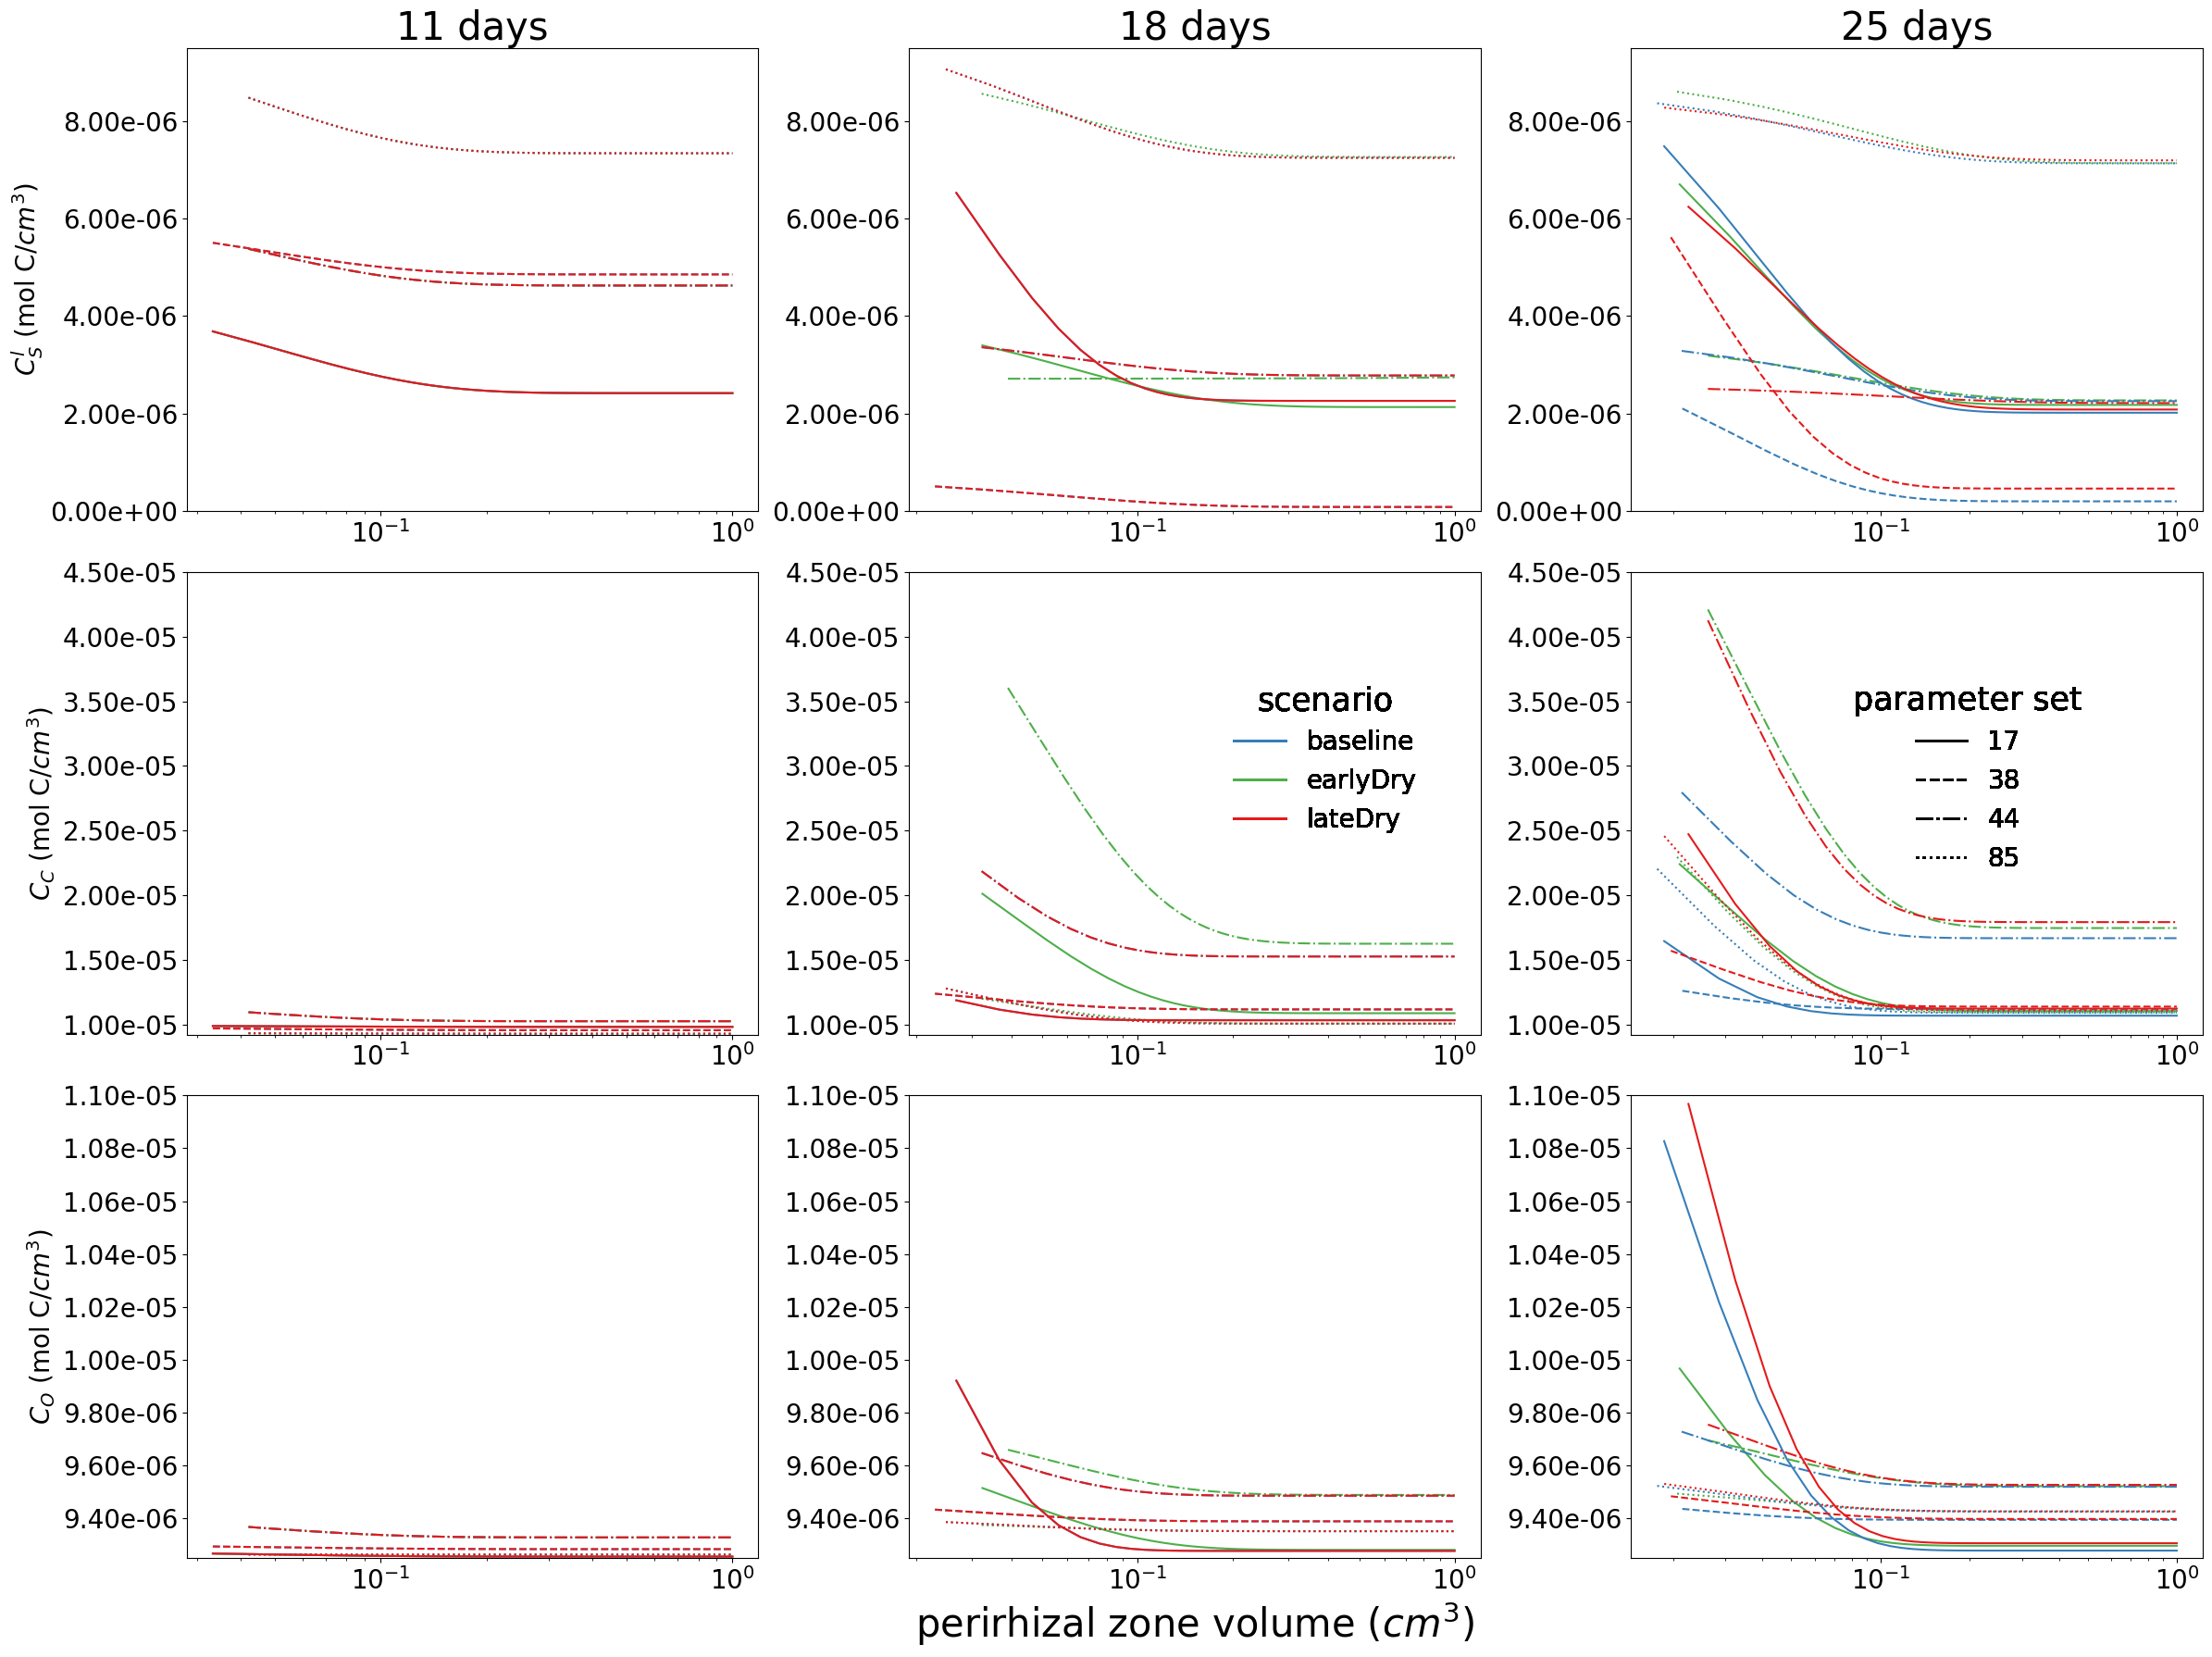

In [188]:

ymins = [0,9.25e-6, 9.25e-6]
ymaxs = [9.5e-6,4.5e-5,1.1e-5]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8*3, 6*3))
for ii, varname in enumerate(['cs','cc','co'] ): 
    for jj, age_ in enumerate([11,18,25] ): 
        getgradcurve(dfall,fig, axes[ii,jj], ii,jj, age= age_, varname = varname, dology = False,
                      ymin=ymins[ii],ymax=ymaxs[ii],
                     dologx = True, anchor2=(0.95, 0.6))
plt.tight_layout()

plt.savefig('gradrootlog.png')
plt.show()
    

In [119]:
#for varname in ['cs','coa','cca','co', 'cc'] :#'css2','co2',       
#    getInitcurve(df18, varname)

#for varname in ['cs','co','coa', 'cc','cca'] :       
#    getgradcurve(df18, varname = varname,anchor1='center', anchor2='center right')

In [120]:
#for varname in ['cs','coa','cca','co', 'cc'] :#'css2','co2',       
#    getInitcurve(df11, varname)

#for varname in ['cs','co','cc','coa', 'cca'] :       
#    getgradcurve(df11, varname = varname,anchor1='center', anchor2='center right')

In [98]:
df11['simulation'].unique()

array(['17_earlyDry', '44_earlyDry', '85_earlyDry', '17_baseline',
       '38_baseline', '44_baseline', '85_baseline', '17_lateDry',
       '38_lateDry', '44_lateDry', '85_lateDry'], dtype=object)

In [123]:
df['time'].unique()

array([25.])

In [127]:
dfall['time'].unique()

array([25, 18, 11])

In [ ]:


survivors = dfall["simulation"].unique()
plt.figure(figsize=(8*2, 6*3))
for pepe in survivors:#df['pSet'].unique():
    df_ = df[df['simulation']==pepe].copy()
    df_data = df[(df['simulation']==pepe)&((df['st']==1)|((df['st']==2)))]
    x_data = df_data['vol']
    y_data = df_data['cs']


    a_fit = df.loc[(df['simulation']==pepe),varname+ 'a_fit'].unique()
    b_fit= df.loc[(df['simulation']==pepe),varname+'b_fit'].unique()  
    c_fit = df.loc[(df['simulation']==pepe), varname+'c_fit'].unique()
    r_squared = df.loc[(df['simulation']==pepe),varname+'r_squared'].unique() 
    # Plot the data and the fitted curve
    x_fit = np.linspace(min(x_data), max(x_data), 100)  # Finer x range for a smooth curve
    y_fit = negative_exponential(x_fit, a_fit, b_fit, c_fit)


    plt.plot(x_fit, y_fit,
             c=c_styles[df_['scenario'].unique()[0]],
             linestyle=l_styles[int(df_['pSet'].unique()[0])]
            )




    plt.xlabel("perirhizal zone volume (cm3)")
    plt.ylabel("mean "+varname+" concentraiton (mol C/cm3)")

    # Create color legend
    color_legend = plt.legend(handles=color_legend_elements, title='scenario', loc='center', frameon=False)

    # Create line style legend
    linestyle_legend = plt.legend(handles=linestyle_legend_elements, title='parameter set', loc='center right',  frameon=False)
    #bbox_to_anchor=(0.88, 1),

    # Add both legends to the plot
    plt.gca().add_artist(color_legend)
    plt.gca().add_artist(linestyle_legend)

    #plt.legend()#loc="lower right")#, fontsize=22))
    #plt.legend(handles=linestyle_legend_elements, title='parameter set', loc=anchor2)#, loc='lower center')
    #plt.legend(handles=color_legend_elements, title='scenario', loc=anchor1)#, loc='upper center'

    # Combine legends

    #plt.gca().add_artist(plt.gca().get_legend_handles_labels()[0])
    # Add the original legends back to the plot
    #plt.add_artist(plt.legend(handles=color_legend_elements, title='scenario', bbox_to_anchor=anchor1))
    #plt.add_artist(plt.legend(handles=linestyle_legend_elements, title='parameter set', bbox_to_anchor=anchor2))
    #pass


plt.show()